In [1]:
import pandas as pd
import numpy as np
import matplotlib
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("AmesHousing.csv")
data = pd.get_dummies(data, columns=['MS Zoning'], prefix='MS_Zoning', dtype=float )
print(data.columns)

Index(['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'G

In [3]:
data = data.select_dtypes(include=['float64', 'int64'])

corr = data.corr()
corr.style.background_gradient( cmap = "coolwarm" )

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS_Zoning_A (agr),MS_Zoning_C (all),MS_Zoning_FV,MS_Zoning_I (all),MS_Zoning_RH,MS_Zoning_RL,MS_Zoning_RM
Order,1.000000,0.173593,0.011797,-0.007034,0.031354,-0.048500,-0.011054,-0.052319,-0.075566,-0.030907,-0.032321,-0.002773,0.005780,-0.028719,-0.013201,-0.000417,0.013589,-0.009342,-0.042539,0.024978,-0.044985,-0.039749,0.015424,-0.017685,0.002612,-0.019156,-0.051160,-0.036185,-0.035435,-0.011292,0.016355,0.027908,-0.024975,0.004307,0.052518,-0.006083,0.133365,-0.975993,-0.031408,0.023592,0.010777,-0.060889,-0.005778,0.001168,-0.008417,0.040846
PID,0.173593,1.000000,-0.001281,-0.096918,0.034868,-0.263147,0.104451,-0.343388,-0.157111,-0.229283,-0.098375,-0.001145,-0.087707,-0.189642,-0.141902,-0.003289,0.056940,-0.107579,-0.037759,0.004328,-0.171431,-0.166636,0.006345,0.076470,-0.068981,-0.108056,-0.256829,-0.237484,-0.210606,-0.051135,-0.071311,0.162519,-0.024894,-0.025735,-0.002845,-0.008260,-0.050455,0.009579,-0.246521,0.028009,0.095704,-0.216970,0.033963,0.005778,-0.239241,0.370244
MS SubClass,0.011797,-0.001281,1.000000,-0.420135,-0.204613,0.039419,-0.067349,0.036579,0.043397,0.002730,-0.060075,-0.070946,-0.130421,-0.219445,-0.247828,0.304237,0.025765,0.068061,0.013701,-0.003329,0.134631,0.175879,-0.019208,0.257698,0.031898,-0.049955,0.088754,-0.045883,-0.103239,-0.017310,-0.014823,-0.022866,-0.037956,-0.050614,-0.003434,-0.029254,0.000350,-0.017905,-0.085092,-0.022921,0.005685,0.167333,-0.004529,0.079223,-0.338442,0.269478
Lot Frontage,-0.007034,-0.096918,-0.420135,1.000000,0.491313,0.212042,-0.074448,0.121562,0.091712,0.222407,0.215583,0.045999,0.116743,0.353773,0.457391,0.029187,0.005249,0.383822,0.108915,-0.024724,0.184521,0.041880,0.240442,0.005407,0.353137,0.257255,0.076306,0.308706,0.358505,0.120084,0.163040,0.012758,0.028564,0.076666,0.173947,0.044476,0.011085,-0.007547,0.357318,0.040798,-0.015099,-0.093974,0.034477,-0.057584,0.354853,-0.334258
Lot Area,0.031354,0.034868,-0.204613,0.491313,1.000000,0.097188,-0.034759,0.023258,0.021682,0.126830,0.191555,0.083150,0.023658,0.253589,0.332235,0.032996,0.000812,0.285599,0.125877,0.026903,0.127433,0.035497,0.136569,-0.020301,0.216597,0.256989,-0.008952,0.179512,0.212822,0.157212,0.103760,0.021868,0.016243,0.055044,0.093775,0.069188,0.003859,-0.023085,0.266549,0.042358,-0.021514,-0.101930,0.096339,-0.034099,0.235117,-0.205188
Overall Qual,-0.048500,-0.263147,0.039419,0.212042,0.097188,1.000000,-0.094812,0.597027,0.569609,0.429418,0.284118,-0.041287,0.270058,0.547294,0.477837,0.241402,-0.048680,0.570556,0.167858,-0.041647,0.522263,0.268853,0.063291,-0.159744,0.380693,0.393007,0.570569,0.599545,0.563503,0.255663,0.298412,-0.140332,0.018240,0.041615,0.030399,0.005179,0.031103,-0.020719,0.799262,-0.094385,-0.143012,0.185284,-0.048071,-0.049527,0.141725,-0.210983
Overall Cond,-0.011054,0.104451,-0.067349,-0.074448,-0.034759,-0.094812,1.000000,-0.368773,0.047680,-0.135340,-0.050935,0.041134,-0.136819,-0.173344,-0.157052,0.006218,0.009175,-0.115643,-0.042766,0.084455,-0.214316,-0.088127,-0.006137,-0.086386,-0.089816,-0.031702,-0.326017,-0.181557,-0.153754,0.020344,-0.068934,0.071459,0.043852,0.044055,-0.016787,0.034056,-0.007295,0.031207,-0.101697,-0.036760,-0.043668,-0.110193,-0.072036,-0.007086,-0.069963,0.165019
Year Built,-0.052319,-0.343388,0.036579,0.121562,0.023258,0.597027,-0.368773,1.000000,0.612095,0.313292,0.279870,-0.027415,0.128998,0.407526,0.310463,0.016828,-0.144282,0.241726,0.211849,-0.030626,0.469406,0.269268,-0.055093,-0.137852,0.111919,0.170672,0.834849,0.537443,0.480131,0.228964,0.198365,-0.374364,0.01

In [4]:
columns_subset  = [
    'Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Year Built', 
    'Full Bath', 'Year Remod/Add', 'Mas Vnr Area', 
    'Fireplaces', 'Open Porch SF', 'MS_Zoning_RM', 'Lot Area', 
    'MS_Zoning_RL', 'Lot Frontage', 'SalePrice'
]




# Subset the data
subset_data = data[columns_subset]
subset_data = subset_data.fillna(0)
corr = subset_data.corr()
corr.style.background_gradient( cmap = "coolwarm" )


,Overall Qual,Gr Liv Area,Garage Area,Total Bsmt SF,Year Built,Full Bath,Year Remod/Add,Mas Vnr Area,Fireplaces,Open Porch SF,MS_Zoning_RM,Lot Area,MS_Zoning_RL,Lot Frontage,SalePrice
Overall Qual,1.000000,0.570556,0.563562,0.547766,0.597027,0.522263,0.569609,0.423089,0.393007,0.298412,-0.210983,0.097188,0.141725,0.128840,0.799262
Gr Liv Area,0.570556,1.000000,0.483971,0.445108,0.241726,0.630321,0.316855,0.400703,0.454924,0.340857,-0.151704,0.285599,0.131765,0.186767,0.706780
Garage Area,0.563562,0.483971,1.000000,0.485608,0.480726,0.406497,0.375566,0.370479,0.294262,0.233229,-0.252373,0.212749,0.195730,0.186780,0.640138
Total Bsmt SF,0.547766,0.445108,0.485608,1.000000,0.407764,0.325434,0.298393,0.393530,0.333467,0.245941,-0.259397,0.253765,0.255586,0.206080,0.632529
Year Built,0.597027,0.241726,0.480726,0.407764,1.000000,0.469406,0.612095,0.306797,0.170672,0.198365,-0.411809,0.023258,0.288249,0.026130,0.558426
Full Bath,0.522263,0.630321,0.406497,0.325434,0.469406,1.000000,0.457266,0.254471,0.229793,0.258675,-0.214705,0.127433,0.121708,0.082826,0.545604
Year Remod/Add,0.569609,0.316855,0.375566,0.298393,0.612095,0.457266,1.000000,0.191740,0.133322,0.241748,-0.185315,0.021682,0.091854,0.069509,0.532974
Mas Vnr Area,0.423089,0.400703,0.370479,0.393530,0.306797,0.254471,0.191740,1.000000,0.270051,0.140003,-0.111689,0.125950,0.104878,0.109858,0.502196
Fireplaces,0.393007,0.454924,0.294262,0.333467,0.170672,0.229793,0.133322,0.270051,1.000000,0.159637,-0.189211,0.256989,0.218219,0.051240,0.474558
Open Porch SF,0.298412,0.340857,0.233229,0.245941,0.198365,0.258675,0.241748,0.140003,0.159637,1.000000,-0.085534,0.103760,-0.021570,0.085480,0.312951


<Axes: xlabel='Year Built', ylabel='SalePrice'>

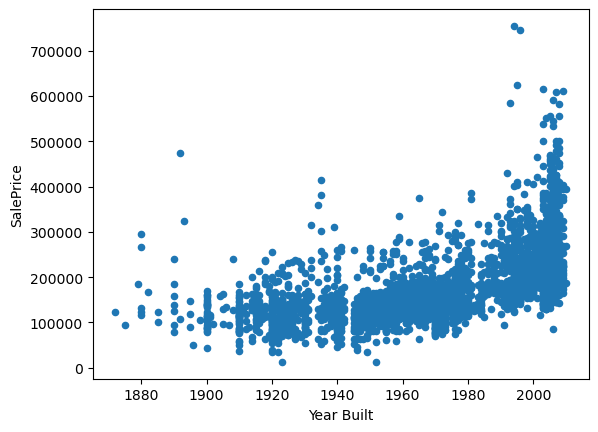

In [5]:
subset_data.plot.scatter("Year Built", "SalePrice")

In [6]:
class PowColumn(BaseEstimator, TransformerMixin):
    def __init__(self, pow=1):
        self.pow = pow
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.power(X, self.pow)

class SelectColumns( BaseEstimator, TransformerMixin ):
    # pass the function we want to apply to the column 'SalePrice’
    def __init__( self, columns ):
        self.columns = columns
        # don't need to do anything
    def fit( self, xs, ys, **params ):
        return self
    # actually perform the selection
    def transform( self, xs ):
        return xs[ self.columns ]

class SelectAndTransformColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = pd.DataFrame()
        for col, func in self.columns.items():
            if col in X.columns:
                if func is None:
                    X_transformed[col] = X[col]  # no transformation
                else:
                    X_transformed[col] = func(X[col])  # apply transformation function
        return X_transformed


In [7]:
pipeline = Pipeline([
    ('column_select', SelectColumns(columns=columns_subset)),
    ('pow_transform', PowColumn()),  # Custom power transformation
    ('linear_regression', LinearRegression(n_jobs=-1))  # Linear regression model
])

columns_subset  = [
    'Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Year Built', 
    'Full Bath', 'Year Remod/Add', 'Mas Vnr Area', 
    'Fireplaces', 'Open Porch SF', 'MS_Zoning_RM', 'Lot Area', 
    'MS_Zoning_RL', 'Lot Frontage'
]

new_col_subset = ['Gr Liv Area', 'Overall Qual', 'Year Built', 'MS_Zoning_RL' ]

# Define the parameter grid for GridSearchCV
grid = {
    'column_select__columns': [
    columns_subset[:1],
    columns_subset[:2],
    columns_subset[:3],
    columns_subset[:4],
    columns_subset[:5],
    columns_subset[:6],
    columns_subset[:7],
    columns_subset[:8],
    columns_subset[:9],
    columns_subset[:10],
    columns_subset[:11],
    columns_subset[:12],
    columns_subset[:13],
    columns_subset[:14],
    new_col_subset,
    [ 'Gr Liv Area', 'Overall Qual', 'Year Built' ],
    
],
    'pow_transform__pow': [1, 2],  # Test no transformation and square
    'linear_regression': [
        LinearRegression(n_jobs=-1),  # No transformation
        TransformedTargetRegressor(
            regressor=LinearRegression(n_jobs=-1),
            func=np.sqrt,
            inverse_func=np.square),  # Square root transform
        TransformedTargetRegressor(
            regressor=LinearRegression(n_jobs=-1),
            func=np.cbrt,
            inverse_func=lambda y: np.power(y, 3)),  # Cube root transform
        TransformedTargetRegressor(
            regressor=LinearRegression(n_jobs=-1),
            func=np.log,
            inverse_func=np.exp),  # Log transform
    ]
}

In [8]:
x = subset_data.drop( columns = [ 'SalePrice' ] )
y = subset_data[ 'SalePrice' ]

search = GridSearchCV(pipeline, param_grid=grid, cv=5, scoring='r2')
search.fit(x, y)

# Output the best score and the best parameters
print("Best R^2 score:", search.best_score_)
print("Best parameters:", search.best_params_)

Best R^2 score: 0.7978426588019947
Best parameters: {'column_select__columns': ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Year Built', 'Full Bath', 'Year Remod/Add', 'Mas Vnr Area', 'Fireplaces', 'Open Porch SF', 'MS_Zoning_RM', 'Lot Area'], 'linear_regression': LinearRegression(n_jobs=-1), 'pow_transform__pow': 1}


<Axes: xlabel='Lot Frontage', ylabel='SalePrice'>

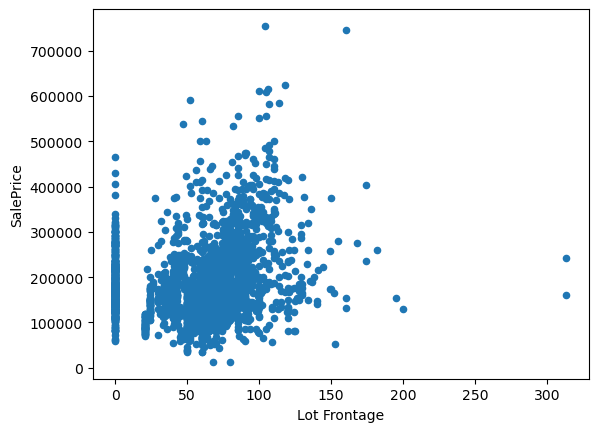

In [9]:
subset_data.plot.scatter("Lot Frontage", "SalePrice")




In [11]:
pipeline = Pipeline([
    ('select_and_transform', SelectAndTransformColumns()),  # Combined selection and transformation
    ('linear_regression', LinearRegression(n_jobs=-1))  # Linear regression model
])

columns_subset  = [
    'Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Year Built', 
    'Full Bath', 'Year Remod/Add', 'Mas Vnr Area', 
    'Fireplaces', 'Open Porch SF', 'MS_Zoning_RM', 'Lot Area', 
    'MS_Zoning_RL', 'Lot Frontage'
]

grid = {
    'select_and_transform__columns': [
        # {'Gr Liv Area': None}, 
        # {'Gr Liv Area': np.log},  
        # {'Gr Liv Area': np.sqrt},  
        # {'Gr Liv Area': None, 'Overall Qual': None},  
        # {'Gr Liv Area': np.log, 'Overall Qual': None},  
        # {'Gr Liv Area': np.sqrt, 'Overall Qual': np.sqrt},  
        # {'Gr Liv Area': np.sqrt, 'Overall Qual': np.sqrt, 'Year Built': None, 'MS_Zoning_RM': None},

        # #{'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': None, 'MS_Zoning_RM': None},
        # #{'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': None},
        # #{'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': np.sqrt},

        # {'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': np.sqrt, 'MS_Zoning_RM': None},

        # {'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': np.sqrt, 'MS_Zoning_RM': None, 
        #  'Full Bath': None, 'Garage Area': None, 'Open Porch SF': None},

        #  {'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': np.sqrt, 'MS_Zoning_RM': None, 
        #  'Full Bath': None, 'Garage Area': None},

        #  {'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': np.sqrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.square},

        # {'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': np.sqrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None},

        # {'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': np.sqrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.sqrt,},

        # # current best
        # {'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': np.sqrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.sqrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.sqrt},

        # {'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': np.square, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.sqrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.sqrt},

        # {'Gr Liv Area': np.sqrt, 'Overall Qual': np.square, 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.sqrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': np.square, 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': np.square, 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': lambda x: np.power(x, 3), 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': lambda x: np.power(x, 3), 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt, 'Mas Vnr Area':None},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': lambda x: np.power(x, 3), 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt, 'Mas Vnr Area':None,
        # 'Fireplaces': None},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': lambda x: np.power(x, 3), 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt,
        # 'Fireplaces': None},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': lambda x: np.power(x, 3), 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt,
        # 'Fireplaces': None, 'Lot Area': None},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': lambda x: np.power(x, 3), 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt,
        # 'Fireplaces': None, 'Lot Area': np.sqrt},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': lambda x: np.power(x, 3), 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt,
        # 'Fireplaces': None, 'Lot Area': np.cbrt},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': lambda x: np.power(x, 3), 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt,
        # 'Fireplaces': None, 'Lot Area': np.cbrt, 'MS_Zoning_RL': None},

        # {'Gr Liv Area': np.cbrt, 'Overall Qual': lambda x: np.power(x, 3), 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        # 'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.sqrt, 'Year Remod/Add': np.cbrt,
        # 'Fireplaces': None, 'Lot Area': np.cbrt, 'Lot Frontage': np.cbrt},
## current best
        {'Gr Liv Area': np.cbrt, 'Overall Qual': lambda x: np.power(x, 3), 'Year Built': np.cbrt, 'MS_Zoning_RM': None, 
        'Garage Area': None, 'Total Bsmt SF': np.cbrt, 'Full Bath': np.cbrt, 'Year Remod/Add': np.cbrt,
        'Fireplaces': None, 'Lot Area': np.cbrt},

    ],
    'linear_regression': [
        LinearRegression(n_jobs=-1),  # No transformation
        TransformedTargetRegressor(
            regressor=LinearRegression(n_jobs=-1),
            func=np.sqrt,
            inverse_func=np.square),  # Square root transform
        TransformedTargetRegressor(
            regressor=LinearRegression(n_jobs=-1),
            func=np.cbrt,
            inverse_func=lambda y: np.power(y, 3)),  # Cube root transform
        TransformedTargetRegressor(
            regressor=LinearRegression(n_jobs=-1),
            func=np.log,
            inverse_func=np.exp),  # Log transform
    ]
}

# set up grid
search = GridSearchCV(pipeline, param_grid=grid, cv=5, scoring='r2')
search.fit(x, y)

# output the best score and the best parameters
print("Linear regression:")
print("R-squared: " + str(search.best_score_))
print("Best params: " + str(search.best_params_))

Linear regression:
R-squared: 0.8371936928971564
Best params: {'linear_regression': TransformedTargetRegressor(func=<ufunc 'sqrt'>, inverse_func=<ufunc 'square'>,
                           regressor=LinearRegression(n_jobs=-1)), 'select_and_transform__columns': {'Gr Liv Area': <ufunc 'cbrt'>, 'Overall Qual': <function <lambda> at 0x0000013907D24180>, 'Year Built': <ufunc 'cbrt'>, 'MS_Zoning_RM': None, 'Garage Area': None, 'Total Bsmt SF': <ufunc 'cbrt'>, 'Full Bath': <ufunc 'cbrt'>, 'Year Remod/Add': <ufunc 'cbrt'>, 'Fireplaces': None, 'Lot Area': <ufunc 'cbrt'>}}
